In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from gensim.models import Word2Vec
import spacy; from spacy.lang.en import English; nlp = English()
from metrics import *
from utils import *

In [2]:
data = getData()

/home/pranav_pro/SchoolSystem/models/essay/utils.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  data['illegible']=data.essay.str.contains('(\?\?\?|illegible|not legible)')


In [3]:
w2vModel = Word2Vec.load('Essayw2v.model')
w2v = dict(zip(w2vModel.wv.index2word, w2vModel.wv.syn0))

/home/pranav_pro/SchoolSystem/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [4]:
def convert2vec(essay):
    essay = basicClean(essay)
    essay = replaceNER(essay)
    essay = nlp(essay)
#     essay = [token.text for token in essay if ((not token.is_punct) and (not token.is_stop))]
    essay = [token.text for token in essay if (not token.is_punct)]

    found = 0
    embedding = np.zeros(300,dtype="float32")
    for word in essay:
        if word in w2v:
            found+=1
            embedding += w2v[word]
    if found>0:
        embedding = np.divide(embedding,found)
    return embedding

In [5]:
tqdm.pandas()
data['emb'] = data['essay'].progress_apply(lambda x: convert2vec(x))

100%|██████████| 12701/12701 [00:21<00:00, 598.24it/s]


In [6]:
data['final_score'] = data['domain1_score']
mul = [5,10,20,20,15,15,2,1]
data['final_score'] = data.apply(lambda row: row['final_score']*mul[row['essay_set']-1], axis=1)
# nndata.groupby('essay_set').describe()
# data.describe()
data.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,emb,final_score
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.4341401, 0.3484266, -0.0023661503, -0.19002...",40
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.455531, 0.36978564, 0.09307918, -0.08629133...",45
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.39665243, 0.23396325, 0.020574056, -0.13223...",35
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.42362538, 0.2999937, -0.06951589, -0.024058...",50
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.35722917, 0.33758688, 0.26486138, -0.109733...",40


In [23]:
def buildData():  
    nndata = data.copy()
#     nndata = nndata[(nndata['essay_set']!=7) & (nndata['essay_set']!=8)]
    nndata = nndata[['emb', 'final_score']]
    train_data = nndata.sample(frac=0.9)
    test_data = nndata.drop(train_data.index)
    train_labels = train_data.pop('final_score')
    test_labels = test_data.pop('final_score')

    trainX = np.zeros((len(train_data['emb']),300))
    for i,emb in enumerate(train_data['emb']):
        trainX[i]=emb
    testX = np.zeros((len(test_data['emb']),300))
    for i,emb in enumerate(test_data['emb']):
        testX[i]=emb
    trainY=np.array(train_labels)/60
    testY=np.array(test_labels)/60
#     np.shape(trainX)
    return trainX, trainY, testX, testY

In [24]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=(300,)),
    layers.Dropout(0.5),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dropout(0.5),
    layers.Dense(1,activation="linear")
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_squared_error'])
  return model

In [25]:
from tensorflow.keras.callbacks import Callback

class IntervalEvaluation(Callback):
    def __init__(self, validation_data=(), interval=10):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_proba(self.X_val, verbose=0)
            score = kappa(self.y_val, y_pred,weights='quadratic')
            print("interval evaluation - epoch: {:d} - score: {:.6f}".format(epoch, score))

In [27]:
trainX, trainY, testX, testY = buildData()
model = build_model()
model.summary()
#sess = tf.Session()
ival = IntervalEvaluation(validation_data=(testX, testY), interval=1)
history = model.fit(trainX, trainY, epochs=50,  callbacks=[ival], validation_split = 0.1, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                19264     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 27,713
Trainable params: 27,713
Non-trainable params: 0
_________________________________________________________________
Train on 10287 samples, validate on 1144 samples
Epoch 1/50
10287/10287 [==============================] - 2s 175us/sample - loss: 0.0784 

Epoch 23/50
10287/10287 [==============================] - 1s 145us/sample - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.0300 - val_mean_squared_error: 0.0300
Epoch 24/50
10287/10287 [==============================] - 1s 138us/sample - loss: 0.0264 - mean_squared_error: 0.0264 - val_loss: 0.0298 - val_mean_squared_error: 0.0298
Epoch 25/50
10287/10287 [==============================] - 1s 140us/sample - loss: 0.0264 - mean_squared_error: 0.0264 - val_loss: 0.0291 - val_mean_squared_error: 0.0291
Epoch 26/50
10287/10287 [==============================] - 1s 135us/sample - loss: 0.0262 - mean_squared_error: 0.0262 - val_loss: 0.0295 - val_mean_squared_error: 0.0295
Epoch 27/50
10287/10287 [==============================] - 1s 137us/sample - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 0.0300 - val_mean_squared_error: 0.0300
Epoch 28/50
10287/10287 [==============================] - 1s 137us/sample - loss: 0.0257 - mean_squared_error: 0.0257 - val_loss: 0.0292 - val_m

Epoch 49/50
10287/10287 [==============================] - 1s 95us/sample - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0276 - val_mean_squared_error: 0.0276
Epoch 50/50
10287/10287 [==============================] - 1s 104us/sample - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0271 - val_mean_squared_error: 0.0271


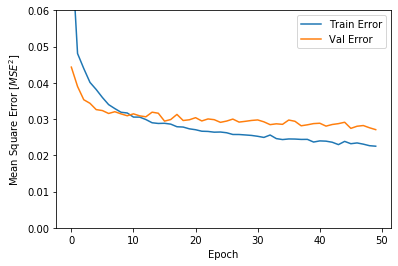

In [35]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MSE^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,0.06])
  plt.legend()
  plt.show()


plot_history(history)

In [29]:
model.save("EssayModel.h5")

In [40]:
ans = model.predict(trainX)


In [41]:
testY

array([0.5       , 0.66666667, 0.66666667, ..., 0.16666667, 0.73333333,
       0.53333333])

In [47]:
c=0
for x in trainY:
    if(x>0.1):
        c+=1
print(c)

11045


In [46]:
c=0
for x in ans:
    if(x>0.1):
        c+=1
print(c)

11430
